# Ensemble methods: Technical preamble

## Interactivity

Please, run the next cell and **refresh the page with the notebook** in your browser.

This enables interactive features.

In [21]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Enable interactivity

In [22]:
from ipywidgets import widgets

Interactive sliders

In [23]:
def int_slider(value, min, max, step):
    return widgets.IntSlider(
        value=value, min=min, max=max, step=step, 
        continuous_update=False, layout=widgets.Layout(min_width='500px', display='flex'))

def float_slider(value, min, max, step):
    return widgets.FloatSlider(
        value=value, min=min, max=max, step=step,
        continuous_update=False, layout=widgets.Layout(min_width='500px', display='flex'))

## Imports and declarations

In [24]:
import numpy  as np

%matplotlib inline
import matplotlib.pyplot as plt

Scikit learn service imports

In [25]:
from sklearn import datasets
from sklearn.metrics import explained_variance_score

from sklearn.model_selection import train_test_split
    
from sklearn.utils import check_random_state

Service functions for plotting

In [26]:
def plot_regression_one_axis(axis, estimator, y_true, fmt="%(name)s $R^2$:%(r_sq)0.2f"):
    if hasattr(estimator, "estimators_"):
        for est_ in estimator.estimators_:
            axis.plot(X_test, est_.predict(X_test),
                      "purple", alpha=0.05)

    axis.scatter(X_train, y_train, c="black",
                 label="train", alpha=0.5)

    y_pred = estimator.predict(X_test)
    axis.plot(X_test, y_pred, c="orange", lw=4,
              label="$\\hat{f}^{*\\mathtt{bag}}(x)$")
    axis.plot(X_test, y_true, c="cyan",
              label="$f(x)$")

    axis.legend(fontsize="large", loc="upper left",
                ncol=3, shadow=True)
    axis.set_xlabel("x")

    axis.set_title(fmt%dict(name=estimator.__class__.__name__,
                            r_sq=explained_variance_score(y_test, y_pred),
                            **estimator.__dict__))
    return axis

def plot_pair_figure(top, bottom, y_true, fmt="%(name)s $R^2$:%(r_sq)0.2f"):
    fig = plt.figure(figsize=(12, 9))

    plot_regression_one_axis(fig.add_subplot(211),
                             top, y_true, fmt)
    plot_regression_one_axis(fig.add_subplot(212),
                             bottom, y_true, fmt)
    return fig


<br/>
<br/>
<hr/>
<br/>
<br/>

# Ensemble methods: Practical session

## Regression

In [27]:
from xgboost import XGBRegressor

from sklearn.ensemble import BaggingRegressor, \
                             RandomForestRegressor, \
                             AdaBoostRegressor, \
                             GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

Toy data generator

In [28]:
def f(X):
    X = X.ravel()
    return np.sin(3*X) + 1.5 * np.exp(-(X - 2) ** 2) - np.exp(-(X+1) ** 2)

def make_regression(n_samples, noise=0.15, random_state=None):
    random_state = check_random_state(random_state)
    X = np.sort(random_state.uniform(-5, 5, size=n_samples))
    y = f(X) + random_state.normal(0.0, noise, size=n_samples)
    return X.reshape(-1, 1), y.reshape(-1)

Generate some synthetic data

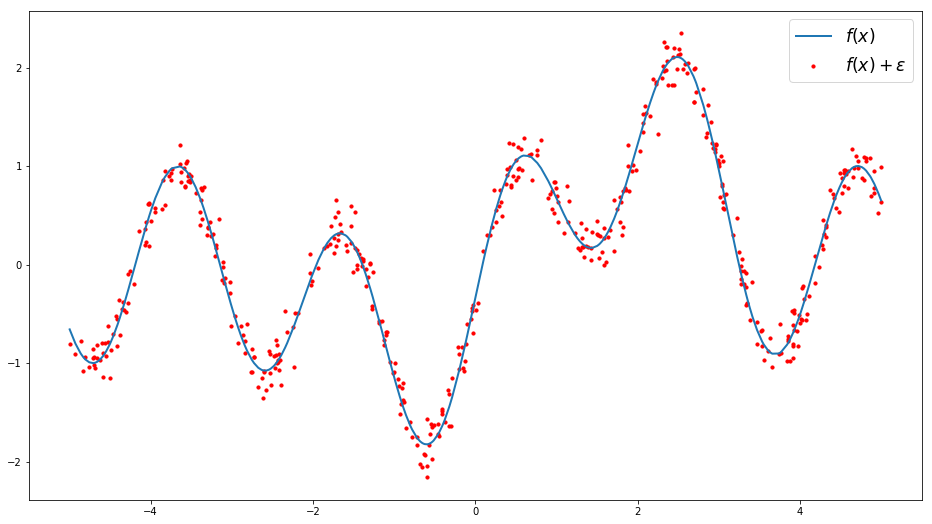

In [29]:
X, y = make_regression(501, random_state=0x0BADF01D)

ax = plt.figure(figsize=(16, 9)).add_subplot(111)
ax.scatter(X, y, c="r", s=10, label="$f(x) + \epsilon$")
ax.plot(X, f(X), lw=2, label="$f(x)$");
ax.legend(fontsize="xx-large");

Train/test split

In [30]:
split_ = train_test_split(X, y, test_size=0.5,
                          random_state=0x0DEADA55, )

X_train, X_test, y_train, y_test = split_

Sort the dataset

In [31]:
y_train = y_train[X_train.argsort(axis=0)[:, 0]]
X_train.sort(axis=0)
y_test = y_test[X_test.argsort(axis=0)[:, 0]]
X_test.sort(axis=0)

### Bagging

Key hyperparameters:
* depth of each regression tree $\hat{f}$ (`max_depth`)
* size of the ensemble $T$ (``n_estimators``)
* bootstrap sample size ratio $\frac{n}{m}$ (``max_samples``)

In [32]:
def BaggingRegressor_plot(max_depth=None, n_estimators=10, max_samples=1.0):
    estimator = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=max_depth),
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=0x10AFF00D)
    
    estimator.fit(X_train, y_train)
    
    plot_regression_one_axis(
        plt.figure(figsize=(12, 6)).add_subplot(111), estimator,
        f(X_test), fmt="""%%(name)s (%s, %%(n_estimators)d, """ \
               """%%(max_samples)0.2f) $R^2$:%%(r_sq)0.2f"""%(
                   "$\\infty$" if max_depth is None else max_depth,))
    plt.show()

Let's see how they affect the ensemble

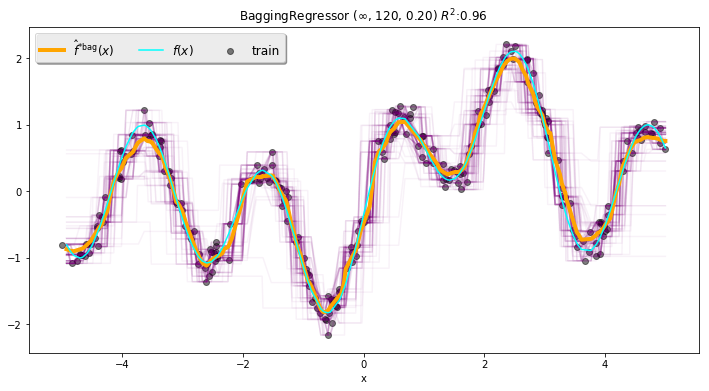

In [33]:
widgets.interact(BaggingRegressor_plot,
                 n_estimators=int_slider(120, 1, 250, 10),
                 max_samples=float_slider(0.20, 0.05, 1.0, 0.05),
                 max_depth={"1": 1, "2": 2, "3": 3, "5": 5, "∞": None});

A side-by-side comparison

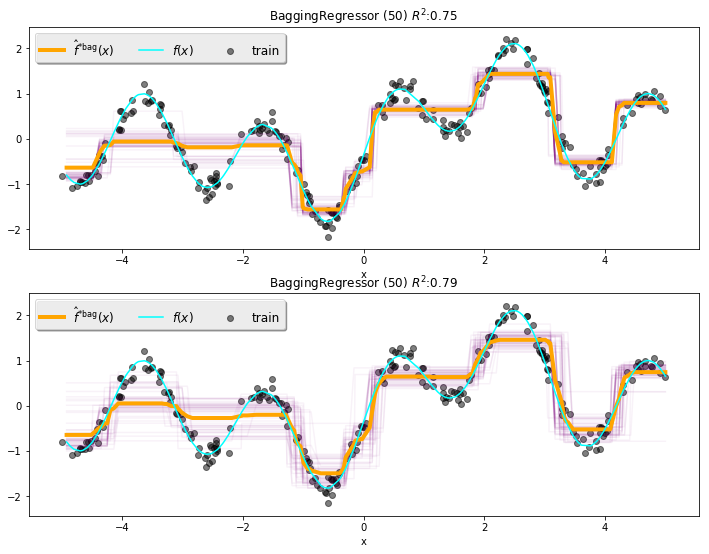

In [34]:
top = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=50,
        max_samples=1.00,
        random_state=0x10AFF00D)

bottom = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=50,
        max_samples=0.25,
        random_state=0x10AFF00D)

plot_pair_figure(top.fit(X_train, y_train), bottom.fit(X_train, y_train),
                 f(X_test), fmt="%(name)s (%(n_estimators)d) $R^2$:%(r_sq)0.2f");

### AdaBoost

Key hyperparamters:
* depth of each regression tree $\hat{f}$ (`max_depth`)
* base estimator calss $\hat{f}$ (`base_estimator`)
* size of the ensemble $T$ (``n_estimators``)

In [35]:
def AdaBoostRegressor_plot(max_depth=1, n_estimators=10):
    estimator = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=max_depth),
        n_estimators=n_estimators,
        random_state=0x10AFF00D)

    estimator.fit(X_train, y_train)

    plot_regression_one_axis(
        plt.figure(figsize=(12, 6)).add_subplot(111), estimator,
        f(X_test), fmt="""%%(name)s (%s, %%(n_estimators)d) $R^2$:%%(r_sq)0.2f"""%(
                   "$\\infty$" if max_depth is None else max_depth,))

    plt.show()

Let's see how they affect the ensemble

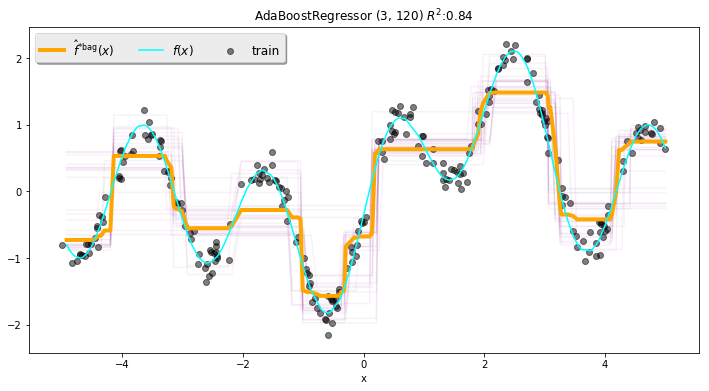

In [36]:
widgets.interact(AdaBoostRegressor_plot,
                 n_estimators=int_slider(120, 1, 250, 10),
                 max_depth=int_slider(3, 1, 20, 1));

A side-by-side comparison

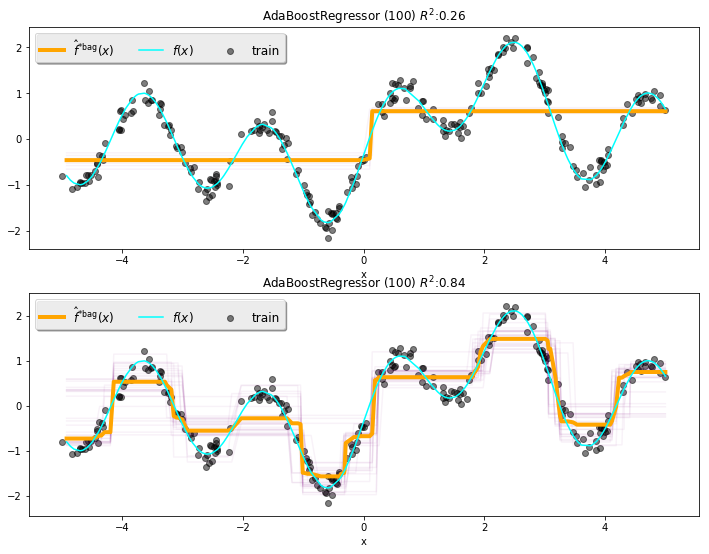

In [37]:
top = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=1),
        n_estimators=100,
        random_state=0x10AFF00D)

bottom = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=100,
        random_state=0x10AFF00D)

plot_pair_figure(top.fit(X_train, y_train), bottom.fit(X_train, y_train),
                 f(X_test), fmt="%(name)s (%(n_estimators)d) $R^2$:%(r_sq)0.2f");

### XGBoost

Key hyperparameters:
* size of the ensemble `n_estimators`
* bootstrap sample size ratio (``subsample``)
* limit on tree depth (``max_depth``)
* $l_1$ penalty (``reg_alpha``)
* $l_2$ penalty (``reg_lambda``)
* tree-depth cost for pruning (``gamma``)
<!-- * fraction of projections for the whole tree (``colsample_bytree``) -->
<!-- * random projection at each split (``colsample_bylevel``) -->

In [38]:
def XGBRegressor_plot(max_depth=3, n_estimators=10,
                       subsample=1.0):
    estimator = XGBRegressor(
        max_depth=max_depth,          # Depth of each regression tree
        n_estimators=n_estimators,    # Size of the ensemble
        subsample=subsample,          # bootstrap share

        reg_alpha=0.0,                # L_1 leaf weight penalty
        reg_lambda=1.0,               # L_2 leaf weight penalty
        gamma=0.0,                    # cost of each new leaf
        learning_rate=0.1,

        objective='reg:linear',
        seed=0x10AFF00D,
        nthread=2)
    
    estimator.fit(X_train, y_train)

    plot_regression_one_axis(
        plt.figure(figsize=(12, 6)).add_subplot(111), estimator,
        f(X_test), fmt="""%(name)s (%(n_estimators)d, %(max_depth)d, """ \
                       """%(subsample)0.2f) $R^2$:%(r_sq)0.2f""")

    plt.show()

Let's see how XGBoost regression depends on the ensemble hyperparamters

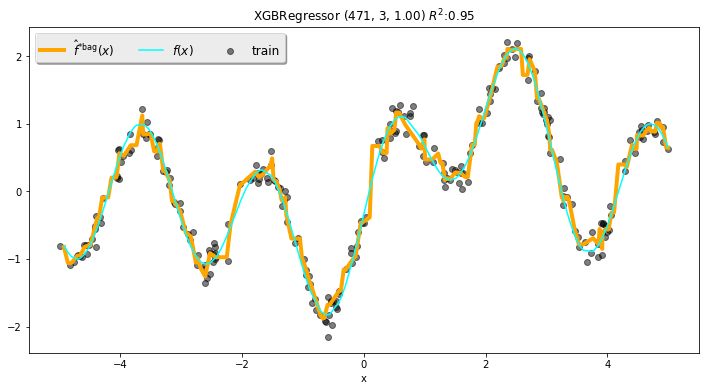

In [39]:
widgets.interact(XGBRegressor_plot,
                 n_estimators=int_slider(10, 1, 1000, 10),
                 max_depth=int_slider(3, 1, 20, 1),
                 subsample=float_slider(1.0, 0.05, 1.0, 0.05));

A side-by-side comparison

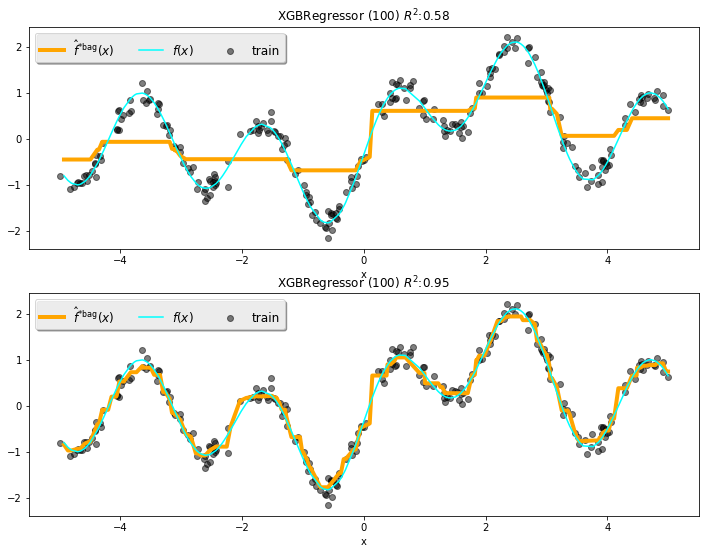

In [40]:
top = XGBRegressor(
        max_depth=1,                  # Depth of each regression tree
        n_estimators=100,             # Size of the ensemble
        subsample=1.0,                # bootstrap share

        reg_alpha=0.0,                # L_1 leaf weight penalty
        reg_lambda=1.0,               # L_2 leaf weight penalty
        gamma=0.0,                    # cost of each new leaf
        learning_rate=0.1,

        objective='reg:linear',
        seed=0x10AFF00D,
        nthread=2)

bottom = XGBRegressor(
        max_depth=3,                  # Depth of each regression tree
        n_estimators=100,             # Size of the ensemble
        subsample=1.0,                # bootstrap share

        reg_alpha=0.0,                # L_1 leaf weight penalty
        reg_lambda=1.0,               # L_2 leaf weight penalty
        gamma=0.0,                    # cost of each new leaf
        learning_rate=0.1,

        objective='reg:linear',
        seed=0x10AFF00D,
        nthread=2)

plot_pair_figure(top.fit(X_train, y_train), bottom.fit(X_train, y_train),
                 f(X_test), fmt="%(name)s (%(n_estimators)d) $R^2$:%(r_sq)0.2f");